https://www.kaggle.com/competitions/home-credit-default-risk/data

## Home Credit Default Risk
Can you predict how capable each applicant is of repaying a loan?

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve

In [4]:
df_train = pd.read_csv('C:/Agapov/Нетология/!Diplom/HomeCredit/application_train.csv')
df_test = pd.read_csv('C:/Agapov/Нетология/!Diplom/HomeCredit/application_test.csv')

In [5]:
df_bureau = pd.read_csv('C:/Agapov/Нетология/!Diplom/HomeCredit/bureau.csv')
df_credit_card_balance = pd.read_csv('C:/Agapov/Нетология/!Diplom/HomeCredit/credit_card_balance.csv')
df_installments_payments = pd.read_csv('C:/Agapov/Нетология/!Diplom/HomeCredit/installments_payments.csv')
df_POS_CASH_balance = pd.read_csv('C:/Agapov/Нетология/!Diplom/HomeCredit/POS_CASH_balance.csv')
df_previous_application = pd.read_csv('C:/Agapov/Нетология/!Diplom/HomeCredit/previous_application.csv')

In [6]:
df_train.shape, df_test.shape

((307511, 122), (48744, 121))

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


1. проверим на пустые значения
2. обработаем категориальные поля OHE

In [8]:
df_train.isna().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64

In [9]:
#узнаем сколько полей с пропусками больше 1\3 и удалим столбцы
(df_train.isna().sum().sort_values(ascending=False) > (len(df_train)/3)).sum()

49

In [10]:
del_columns = df_train.isna().sum().sort_values(ascending=False) > (len(df_train)/3)
del_columns

COMMONAREA_MEDI              True
COMMONAREA_AVG               True
COMMONAREA_MODE              True
NONLIVINGAPARTMENTS_MODE     True
NONLIVINGAPARTMENTS_AVG      True
                            ...  
NAME_HOUSING_TYPE           False
NAME_FAMILY_STATUS          False
NAME_EDUCATION_TYPE         False
NAME_INCOME_TYPE            False
SK_ID_CURR                  False
Length: 122, dtype: bool

In [11]:
del_columns_list = list(del_columns[del_columns == True].index)
df_train.drop(columns = del_columns_list, inplace=True)
df_test.drop(columns = del_columns_list, inplace=True)

In [12]:
df_train.shape, df_test.shape

((307511, 73), (48744, 72))

Обработаем 16 категориальных полей OHE

In [13]:
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

In [14]:
# кол-во полей выросло на 112
df_train.shape, df_test.shape

((307511, 185), (48744, 181))

при этом видим, что разница количества полей между train и test теперь больше 1, значит попались какие то категории, которых нет в тестовой выборке - можем их удалить

In [15]:
difference = set(list(df_train.columns)).difference(set(list(df_test.columns)))
list(difference)

['NAME_INCOME_TYPE_Maternity leave',
 'CODE_GENDER_XNA',
 'TARGET',
 'NAME_FAMILY_STATUS_Unknown']

удаляем все, кроме Target

In [16]:
df_train.drop(['CODE_GENDER_XNA', 'NAME_FAMILY_STATUS_Unknown', 'NAME_INCOME_TYPE_Maternity leave'], axis=1, inplace=True)

In [17]:
if set(list(df_train.columns)).difference(set(list(df_test.columns))) == {'TARGET'}: 
    print('ok')

ok


In [18]:
def imput_median(data):
    """
    Заполяем пропуски медианными значениями
    """
    for col in data.columns:
        median_ = data[col].median()
        data.loc[data[col].isna(), col] = median_
    return data

In [19]:
df_train = imput_median(df_train)
df_test = imput_median(df_test)

df_train.isna().sum().sum(), df_test.isna().sum().sum()

(0, 0)

In [20]:
# Поля 'AMT_CREDIT_SUM', 'Active', 'Closed' из bureau
amt_credit_sum = df_bureau.groupby(['SK_ID_CURR'])['AMT_CREDIT_SUM'].sum().reset_index()
сredit_active = df_bureau.groupby(['SK_ID_CURR', 'CREDIT_ACTIVE'])['CREDIT_ACTIVE'].count().unstack().reset_index()

# Поля из credit_card_balance mean()
credit_card_balance = df_credit_card_balance.groupby(['SK_ID_CURR']).mean().reset_index().fillna(0)

# Поля из installments_payments median
installments_payments = df_installments_payments.groupby(['SK_ID_CURR']).median().reset_index().fillna(0)

# Поля из POS_CASH_balance median
POS_CASH_balance = df_POS_CASH_balance.groupby(['SK_ID_CURR']).median().reset_index().fillna(0)

# Поля из previous_application median
previous_application = df_previous_application.groupby(['SK_ID_CURR']).median().reset_index()

C:\Users\Анна\AppData\Local\Temp\ipykernel_9192\2124469010.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  credit_card_balance = df_credit_card_balance.groupby(['SK_ID_CURR']).mean().reset_index().fillna(0)
C:\Users\Анна\AppData\Local\Temp\ipykernel_9192\2124469010.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  POS_CASH_balance = df_POS_CASH_balance.groupby(['SK_ID_CURR']).median().reset_index().fillna(0)
C:\Users\Анна\AppData\Local\Temp\ipykernel_9192\2124469010.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only wi

In [21]:
on_key = 'SK_ID_CURR'

df_train = df_train.merge(сredit_active[['SK_ID_CURR', 'Active', 'Closed']], how='left', on=on_key)
df_train = df_train.merge(amt_credit_sum, how='left', on=on_key)
df_train = df_train.merge(credit_card_balance, how='left', on=on_key)
df_train = df_train.merge(installments_payments, how='left', on=on_key)
df_train = df_train.merge(previous_application, how='left', on=on_key)

df_test = df_test.merge(сredit_active[['SK_ID_CURR', 'Active', 'Closed']], how='left', on=on_key)
df_test = df_test.merge(amt_credit_sum, how='left', on=on_key)
df_test = df_test.merge(credit_card_balance, how='left', on=on_key)
df_test = df_test.merge(installments_payments, how='left', on=on_key)
df_test = df_test.merge(previous_application, how='left', on=on_key)

In [22]:
df_train.fillna(0, inplace=True)
df_test.fillna(0, inplace=True)
df_train.shape, df_test.shape, df_train.isnull().sum().sum(), df_test.isnull().sum().sum()

((307511, 233), (48744, 232), 0, 0)

Нормализуем данные

In [23]:
from sklearn.preprocessing import StandardScaler

In [24]:
X = df_train.drop(['TARGET'], axis=1)
y = df_train['TARGET']

scaler = StandardScaler()

scaler.fit(X)
X = scaler.transform(X)
X_test = scaler.transform(df_test)

строим Baseline

In [62]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=41)

In [63]:
model = LogisticRegression(max_iter=10000).fit(X_train, y_train)

In [64]:
pred_val = model.predict_proba(X_val)[:, 1]

0.6163255772729574


C:\Users\Анна\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


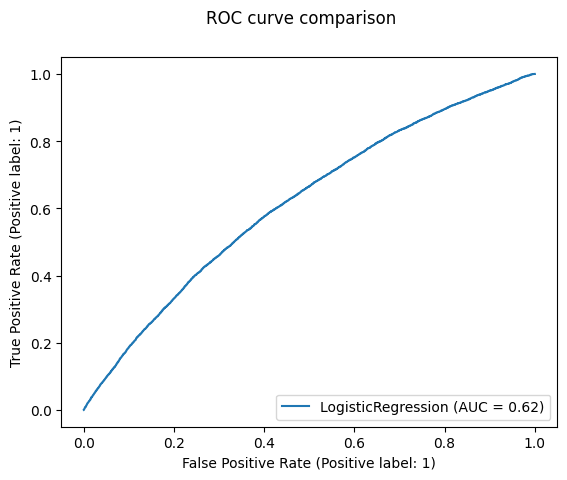

In [66]:
print(roc_auc_score(y_val, pred_val)) # baseline 0.7404927052006007

#0.7427688697157726
#0.7441815087491457
# 0.755456465460733

lr_disp = plot_roc_curve(model, X_val, y_val)
lr_disp.figure_.suptitle("ROC curve comparison")

plt.show()

Построим модель RandomForestClasssifier

In [77]:
X = df_train.drop(['TARGET'], axis=1)
y = df_train['TARGET']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=41)
X_test = df_test

In [78]:
model_rfc_10 = RandomForestClassifier(n_estimators=10,
    max_depth=14,
    min_samples_leaf=1,
    min_samples_split=10).fit(X_train, y_train)

In [79]:
pred_val_rfc_10_prob = model_rfc_10.predict_proba(X_val)[:, 1]
pred_val_rfc_10_bin = model_rfc_10.predict(X_val)

print('RMSE RandomForest_10: ')
print(mean_squared_error(y_val, pred_val_rfc_10_prob, squared=False))

print(f'ROC-AUC score RandomForest_10: {roc_auc_score(y_val, pred_val_rfc_10_prob)}')

RMSE RandomForest_10: 
0.26726720683727945
ROC-AUC score RandomForest_10: 0.7131240880777181


Text(0.5, 0, 'Random Forest Feature Importance')

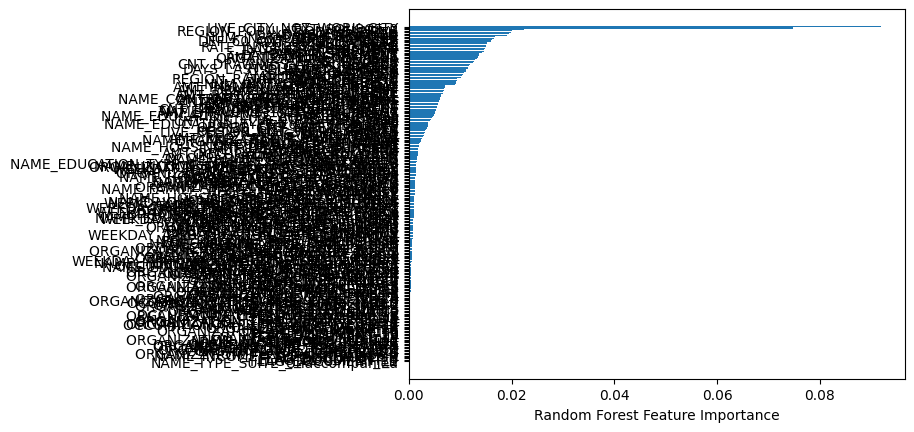

In [48]:
sorted_idx = model_rfc_10.feature_importances_.argsort()
plt.barh(df_train.columns[sorted_idx], model_rfc_10.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.show()

In [80]:
columns_ = df_train.columns[sorted_idx][:40]

X_40 = pd.DataFrame(df_train, columns=columns_)
y = df_train['TARGET']

X_40_train, X_40_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=41)

X_40_test = pd.DataFrame(df_test, columns=columns_)

In [82]:
model_rfc_40 = RandomForestClassifier(n_estimators=50,
    max_features=5,
    max_depth=14,
    min_samples_leaf=1,
    min_samples_split=10).fit(X_40_train, y_train)

model_rfc = RandomForestClassifier(n_estimators=50,
    max_features=5,
    max_depth=14,
    min_samples_leaf=1,
    min_samples_split=10).fit(X_train, y_train)

RMSE RandomForest_40: 
0.2678930919099187
RMSE RandomForest: 
0.26780348095918366
ROC-AUC score RandomForest_40: 0.729717772526783
ROC-AUC score RandomForest: 0.7309045966719225


C:\Users\Анна\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Анна\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


AttributeError: 'RocCurveDisplay' object has no attribute 'show'

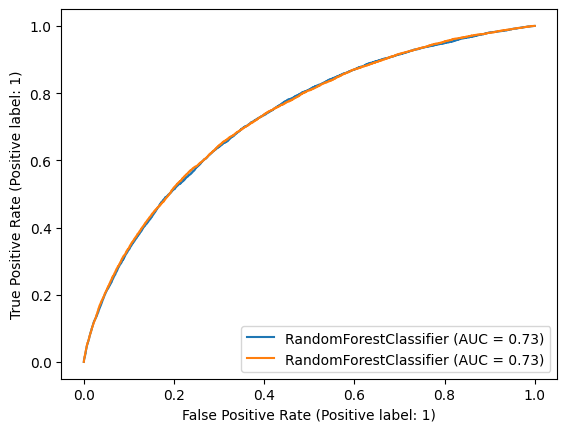

In [84]:
pred_val_rfc_40_prob = model_rfc_40.predict_proba(X_40_val)[:, 1]
pred_val_rfc_40_bin = model_rfc_40.predict(X_40_val)
pred_val_rfc_prob = model_rfc.predict_proba(X_val)[:, 1]
pred_val_rfc_bin = model_rfc.predict(X_val)

print('RMSE RandomForest_40: ')
print(mean_squared_error(y_val, pred_val_rfc_40_prob, squared=False))
print('RMSE RandomForest: ')
print(mean_squared_error(y_val, pred_val_rfc_prob, squared=False))

print(f'ROC-AUC score RandomForest_40: {roc_auc_score(y_val, pred_val_rfc_40_prob)}')
print(f'ROC-AUC score RandomForest: {roc_auc_score(y_val, pred_val_rfc_prob)}')

# скор у модели с 40 наиболее важными признаками
# ROC-AUC score RandomForest: 0.729717772526783
# скор у модели со всеми признаками
# ROC-AUC score RandomForest: 0.7309045966719225

rfc_disp_40 = plot_roc_curve(model_rfc_40, X_40_val, y_val)
rfc_disp = plot_roc_curve(model_rfc, X_val, y_val, ax=rfc_disp_40.ax_)
plt.show()

Построим DecisionTreeClassifier

In [116]:
model_dtc = DecisionTreeClassifier(
    criterion = 'log_loss',
    max_depth=14,
    splitter='best', 
    min_samples_split=10,
    min_samples_leaf=2,
    max_features='auto',
    max_leaf_nodes=100
    ).fit(X_train, y_train)

model_dtc_40 = DecisionTreeClassifier(
    criterion = 'log_loss',
    max_depth=14,
    splitter='best', 
    min_samples_split=10, 
    min_samples_leaf=2, 
    max_features='auto',
    max_leaf_nodes=100
    ).fit(X_40_train, y_train)

C:\Users\Анна\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\Анна\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


ROC-AUC score DTC: 0.6740533526677898
ROC-AUC score DTC: 0.6660590331650895


C:\Users\Анна\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Анна\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


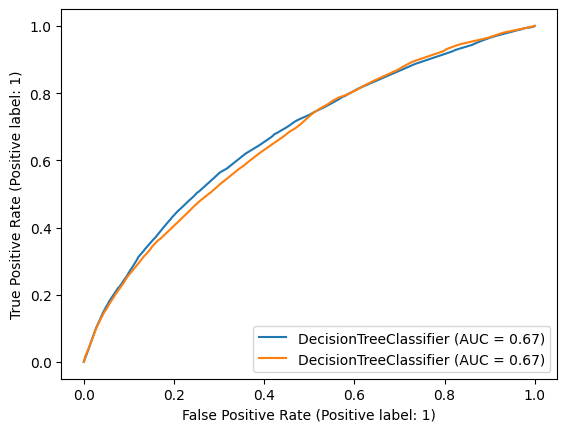

In [117]:
pred_val_dtc = model_dtc.predict_proba(X_val)[:, 1]
pred_val_dtc_40 = model_dtc_40.predict_proba(X_40_val)[:, 1]

print(f'ROC-AUC score DTC: {roc_auc_score(y_val, pred_val_dtc)}')
print(f'ROC-AUC score DTC: {roc_auc_score(y_val, pred_val_dtc_40)}')

# скор у модели со всеми признаками
# ROC-AUC score DTC: 0.6740533526677898
# скор у модели с 40 наиболее важными признаками
# ROC-AUC score DTC: 0.6660590331650895

rfc_disp = plot_roc_curve(model_dtc, X_val, y_val)
rfc_disp_40 = plot_roc_curve(model_dtc_40, X_40_val, y_val, ax=rfc_disp.ax_)
plt.show()

Стеккинг LogReg, RFC и DTC

In [155]:
# вспомним rocauc для отобранных моделей

print(f'ROC-AUC score LogReg: {roc_auc_score(y_val, pred_val)}')
print(f'ROC-AUC score RFC: {roc_auc_score(y_val, pred_val_rfc)}')
print(f'ROC-AUC score DTC: {roc_auc_score(y_val, pred_val_dtc)}')

ROC-AUC score LogReg: 0.4997588692156097


NameError: name 'pred_val_rfc' is not defined

In [118]:
from sklearn.ensemble import StackingClassifier

In [119]:
estimators = [
    ('logreg', model),
    ('rfc', model_rfc),
    ('dtc', model_dtc)
]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

In [122]:
clf.fit(X_train, y_train)

C:\Users\Анна\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\Анна\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\Анна\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featur

StackingClassifier(estimators=[('logreg', LogisticRegression(max_iter=10000)),
                               ('rfc',
                                RandomForestClassifier(max_depth=14,
                                                       max_features=5,
                                                       min_samples_split=10,
                                                       n_estimators=50)),
                               ('dtc',
                                DecisionTreeClassifier(criterion='log_loss',
                                                       max_depth=14,
                                                       max_features='auto',
                                                       max_leaf_nodes=100,
                                                       min_samples_leaf=2,
                                                       min_samples_split=10))],
                   final_estimator=LogisticRegression())

In [123]:
pred_val_clf = clf.predict_proba(X_val)[:, 1]
print(f'ROC-AUC score Stacking: {roc_auc_score(y_val, pred_val_clf)}')
#ROC-AUC score Stacking: 0.7249617157646875

ROC-AUC score Stacking: 0.7249617157646875


In [124]:
pred_test = clf.predict_proba(X_test)[:, 1]

In [125]:
submit = df_test[['SK_ID_CURR']]
submit.loc[:, 'TARGET'] = pred_test

submit.head()

C:\Users\Анна\AppData\Local\Temp\ipykernel_9192\1961238869.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submit.loc[:, 'TARGET'] = pred_test


,SK_ID_CURR,TARGET
0,100001,0.053847
1,100005,0.073002
2,100013,0.047127
3,100028,0.075136
4,100038,0.139246


In [126]:
submit.to_csv('C:/Agapov/Нетология/!Diplom/submit_stacking.csv', index = False)

# Score: 0.71049
# Private score: 0.70717

LightGBM

In [127]:
from lightgbm import LGBMClassifier

In [129]:
import re
df_train = df_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df_test = df_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [ ]:
X = df_train.drop(['TARGET'], axis=1)
y = df_train['TARGET']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

X_test = df_test

In [141]:
model_lgbm = LGBMClassifier()
model_lgbm.fit(X_train, y_train)

LGBMClassifier()

In [142]:
pred_val_lgbm = model_lgbm.predict_proba(X_val)[:,1]
print(f'ROC-AUC score LGBM: {roc_auc_score(y_val, pred_val_lgbm)}')
# 0.7621604770681465

ROC-AUC score LGBM: 0.7621604770681465


In [153]:
pred_test = model_lgbm.predict_proba(X_test)[:, 1]
submit = df_test[['SK_ID_CURR']]
submit.loc[:, 'TARGET'] = pred_test


C:\Users\Анна\AppData\Local\Temp\ipykernel_9192\1363098188.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submit.loc[:, 'TARGET'] = pred_test


In [154]:
submit.to_csv('C:/Agapov/Нетология/!Diplom/submit_lgbm.csv', index = False)

# Score: 0.75000
# Private score: 0.74671

Создаем датасет для выгрузки на Kaggle

In [ ]:
pred_test = model.predict_proba(X_test)[:, 1]

In [ ]:
submit = df_test[['SK_ID_CURR']]
submit.loc[:, 'TARGET'] = pred_test

submit.head()

C:\Users\Анна\AppData\Local\Temp\ipykernel_4268\1961238869.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submit.loc[:, 'TARGET'] = pred_test


,SK_ID_CURR,TARGET
0,100001,0.060271
1,100005,0.222942
2,100013,0.027642
3,100028,0.022305
4,100038,0.106322


In [ ]:
submit.to_csv('C:/Agapov/Нетология/!Diplom/same_submit.csv', index = False)
# BL:  Score: 0.73157
# BL:  Private score: 0.72608

# После добавления Acive Closed
# Score: 0.73331
# Private score: 0.72842

#  После добавления amt_credit_sum и StandardScaler
# Score: 0.73559
# Private score: 0.73012

# После добавления credit_card_balance
# Score: 0.74174
# Private score: 0.73527

# После добавления всех остальных таблиц.median. Model - LogReg
# Score: 0.74956
# Private score: 0.74226


#### Топ-скор на каггл
- Скор на паблике: 0.81724
- Скор на привате: 0.80570

#### Дальнейшие идеи по улучшению модели:
1. Более детально заполнять пропуски, а не медианой
2. Добавить полиномиальные, логарифмированые признаки
3. Потестить еще 2-3 модели
4. Подбор гиперпараметров
5. Ансамбль алгоритмов

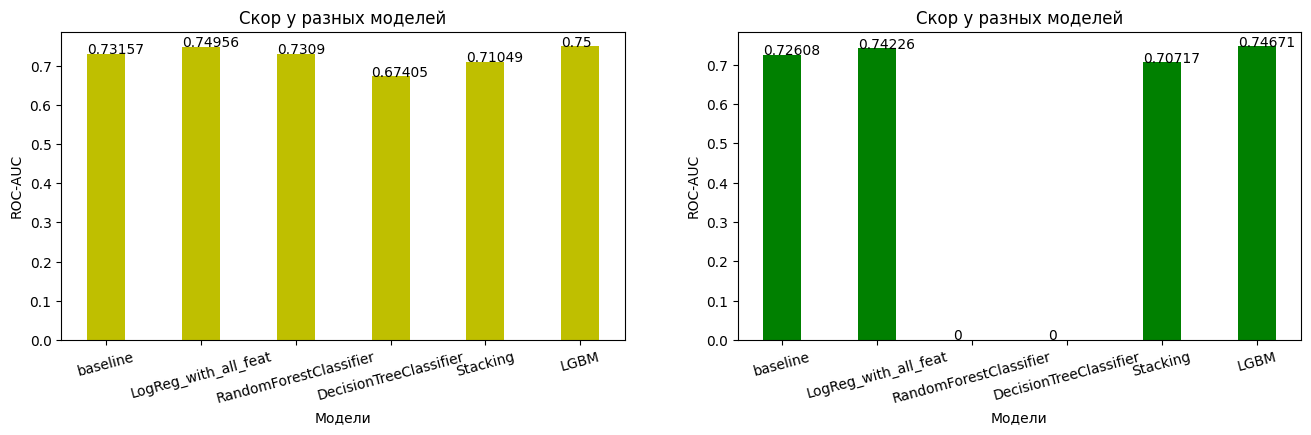

In [207]:
res = {'baseline': [0.73157, 0.72608],
       'LogReg_with_all_feat': [0.74956, 0.74226],
       'RandomForestClassifier': [0.73090, 0],
       'DecisionTreeClassifier': [0.67405, 0],
       'Stacking': [0.71049, 0.70717],
       'LGBM': [0.75000, 0.74671]}

models = list(res.keys())
scores1 = [res[x][0] for x in list(res.keys())]
scores2 = [res[x][1] for x in list(res.keys())]
 
fig = plt.figure(figsize = (16, 4))
 
# creating the bar plot
plt.subplot(121)
plt.bar(models, scores1, color ='y', width = 0.4)
 
plt.xlabel('Модели')
plt.ylabel('ROC-AUC')
plt.title('Скор у разных моделей')
plt.xticks(rotation=15)

[plt.text(i-0.2, x, f'{x}') for i, x in enumerate(scores1)]

plt.subplot(122)
plt.bar(models, scores2, color ='g', width = 0.4)
 
plt.xlabel('Модели')
plt.ylabel('ROC-AUC')
plt.title('Скор у разных моделей')
plt.xticks(rotation=15)

[plt.text(i-0.2, x, f'{x}') for i, x in enumerate(scores2)]

plt.show()